In [16]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('traffic_volume_1hr.csv')

In [17]:
print(data.shape)

(3624, 4)


In [18]:
data.describe()

,month,day,hr,total_volume
count,3624.000000,3624.000000,3624.000000,3624.000000
mean,3.013245,15.622517,12.500000,1955.531457
std,1.423683,8.752171,6.923142,1033.506698
min,1.000000,1.000000,1.000000,432.000000
25%,2.000000,8.000000,6.750000,921.000000
50%,3.000000,16.000000,12.500000,2005.000000
75%,4.000000,23.000000,18.250000,2854.000000
max,5.000000,31.000000,24.000000,4024.000000


In [19]:
print(data.head())

   month  day  hr  total_volume
0      1    1   1          1165
1      1    1   2          1306
2      1    1   3           930
3      1    1   4           818
4      1    1   5           675


In [25]:
df = data['total_volume']
dataset = df.values.astype('float32')
dataset = np.reshape(dataset, (len(dataset),1))

print(dataset.shape)
print(dataset)

(3624, 1)
[[1165.]
 [1306.]
 [ 930.]
 ...
 [1515.]
 [1326.]
 [ 965.]]


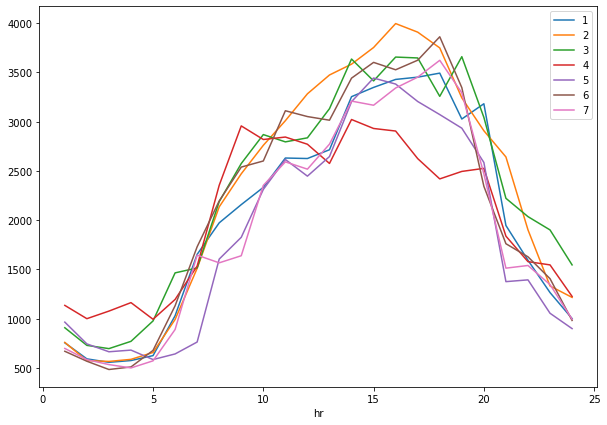

In [36]:
plot_data = data[(data.month == 4) & (data.day <= 7)]
fig, ax = plt.subplots(figsize=(10,7))
plot_data.set_index('hr', inplace=True)
pt = plot_data.groupby('day')['total_volume'].plot(legend=True)



In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD


Using TensorFlow backend.
C:\Users\Dell\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Dell\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Dell\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Dell\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Dell\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompa

In [127]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

In [128]:
print(dataset.head())

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [141]:
dataset=data['total_volume']
train_size=int(len(data)*0.7)
test_size=len(dataset)-train_size

train,test=dataset[:train_size],dataset[train_size:len(dataset)]
print(test.shape)
print(train.shape)
train = train.values.astype('float32')
test = test.values.astype('float32')
train = np.reshape(train,(len(train),1))
test = np.reshape(test,(len(test),1))
print(train.shape)
print(test.shape)

(1088,)
(2536,)
(2536, 1)
(1088, 1)


In [142]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [143]:
def transform_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


look_back = 24
trainX, trainY = transform_dataset(train, look_back)
testX, testY = transform_dataset(test, look_back)
print(trainX.shape)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
print(trainX.shape)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

(2511, 24)
(2511, 24, 1)


In [144]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)

(2511, 24, 1)
(1063, 24, 1)
(2511,)


In [145]:
print(testX.shape)
print(trainY.shape)
print(trainX.shape)

(1063, 24, 1)
(2511,)
(2511, 24, 1)


In [147]:
sgd = SGD(lr=0.1)

model = Sequential()
model.add(LSTM(1, input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=sgd)
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=1)
print(trainY.shape)

trainPredict = model.predict(trainX)
print(trainY.shape)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/5
2511/2511 [==============================] - 22s 9ms/step - loss: 0.0214
Epoch 2/5
2511/2511 [==============================] - 21s 8ms/step - loss: 0.0094
Epoch 3/5
2511/2511 [==============================] - 25s 10ms/step - loss: 0.0089
Epoch 4/5
2511/2511 [==============================] - 22s 9ms/step - loss: 0.0088
Epoch 5/5
2511/2511 [==============================] - 21s 9ms/step - loss: 0.0088
(2511,)
(2511,)


In [149]:
print(testPredict.shape)
print(trainPredict.shape)
print(testY.shape)
print(trainY.shape)

(1063, 1)
(2511, 1)
(1, 1063)
(1, 2511)


In [150]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 318.67 RMSE
Test Score: 350.00 RMSE


In [157]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [158]:
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

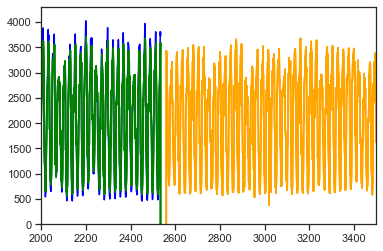

In [169]:
import seaborn as sns
sns.set(style='ticks')
#fig, ax = plt.subplots(figsize=(25,8))
plt.plot(scaler.inverse_transform(train),color='blue')
plt.plot(trainPredictPlot,color='green')
plt.plot(testPredictPlot,color='orange')
plt.xlim(2000, 3500)
plt.ylim(0,4300)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 2000 results in singular transformations; automatically expanding.


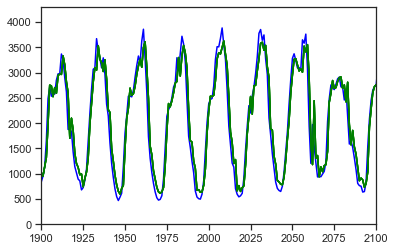

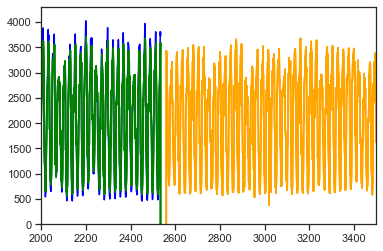

In [179]:
import matplotlib
from matplotlib import pyplot as plt

# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
# plot baseline and predictions

plt.plot(scaler.inverse_transform(train),color='blue')
plt.plot(trainPredictPlot,color='green')
plt.plot(testPredictPlot,color='red')
plt.xlim(2000, 2000)
plt.ylim(0,4300)
plt.show()

plt.plot(scaler.inverse_transform(train),color='blue')
plt.plot(trainPredictPlot,color='green')
plt.plot(testPredictPlot,color='orange')
plt.xlim(2000, 3500)
plt.ylim(0,4300)
plt.show()
